# Modeling de Cancer de Mama

Se prueban inicialmente bajo un train/validation/split los modelos de:

Ahora iniciaremos con modelos de ensamble

  * Bagging
  * Random Forest
  * AdaBoost
  * XGBoost

Y ejecutaremos los visto en las clases anteriores

  * CART
  * ID3
  * CHAID
  * Regresión Logística
  * Knn

In [3]:
# Upload your kaggle.json file (contains API key)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegoalvarez94","key":"b202f69c3cce740ab854f22debd2a985"}'}

In [4]:
# Make directory and move kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c fa-i-2025-i-modelos-tradicionales-ca-mamaII

!unzip fa-i-2025-i-modelos-tradicionales-ca-mamaII.zip

fa-i-2025-i-modelos-tradicionales-ca-mamaII.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fa-i-2025-i-modelos-tradicionales-ca-mamaII.zip
replace Diccionario.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Diccionario.xlsx        
replace df_test.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: df_test.parquet         
replace df_train.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: df_train.parquet        
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   


## Importamos Librerias

In [5]:
import numpy as np  # Algebra lineal, manipulación de arreglos numéricos.
import pandas as pd  # Procesamiento de datos, lectura/escritura de archivos CSV.
import os.path as osp  # Manejo de rutas de archivos.
import pickle  # Serialización y deserialización de objetos Python (guardar/cargar modelos).


# Modelos de clasificación Adicional
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Modelos de clasificación
from sklearn import tree
from sklearn.linear_model import LogisticRegression  # Modelo de regresión logística para clasificación binaria.
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors (KNN) para clasificación basada en distancia.
from sklearn.naive_bayes import GaussianNB  # Clasificador Naive Bayes basado en distribución Gaussiana.

# Preprocesamiento de datos
from sklearn.preprocessing import OneHotEncoder  # Codificación one-hot para variables categóricas nominales.
from sklearn.preprocessing import OrdinalEncoder  # Codificación ordinal para variables categóricas con orden.
from sklearn.preprocessing import StandardScaler  # Normalización de datos para mejorar el rendimiento del modelo.
from sklearn.preprocessing import FunctionTransformer  # Aplicación de transformaciones personalizadas.

# División del conjunto de datos
from sklearn.model_selection import train_test_split  # División en conjunto de entrenamiento y prueba.

# Selección de características
from sklearn.feature_selection import VarianceThreshold  # Elimina características con varianza baja (irrelevantes).
from sklearn.feature_selection import SelectPercentile, chi2  # Selección de características más relevantes con Chi-cuadrado.

# Construcción del pipeline de procesamiento y modelado
from sklearn.compose import ColumnTransformer  # Aplica transformaciones específicas a diferentes columnas.
from sklearn.pipeline import Pipeline, make_pipeline  # Automatiza el flujo de preprocesamiento y modelado.

# Manejo de valores faltantes
from sklearn.impute import SimpleImputer  # Rellena valores faltantes con media, mediana, moda, etc.

# Evaluación de modelos
import sklearn.metrics as skm  # Métricas de rendimiento como precisión, recall, F1-score, AUC-ROC, etc.

# Visualización de datos
import matplotlib.pyplot as plt  # Gráficos y visualización de métricas.
import seaborn as sns  # Visualización avanzada con gráficos estadísticos.

# Medición de tiempos de ejecución
from time import time  # Captura de tiempo de inicio y fin de ejecución.
from datetime import timedelta  # Cálculo de diferencias de tiempo en ejecución.

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Funciones útiles

In [6]:
def get_imbalaced_metrics(y_true, y_preds):
    '''calcula métricas de evaluación para modelos de clasificación cuando los datos están desbalanceados.'''
    ths = np.linspace(0, 1, 1000)
    best_th = ths[
        np.argmax([skm.f1_score(y_true, y_preds>th) for th in ths])
    ]

    roc_auc = skm.roc_auc_score(y_true, y_preds)
    average_precision = skm.average_precision_score(y_true, y_preds)
    max_f1 = skm.f1_score(y_true, y_preds>best_th)
    accuracy_on_max_f1 = skm.accuracy_score(y_true, y_preds>best_th)
    kappa = skm.cohen_kappa_score(y_true, y_preds>best_th)
    baseline=y_true.value_counts(True)


    return dict(
        roc_auc=roc_auc,
        average_precision=average_precision,
        max_f1=max_f1,
        accuracy_on_max_f1=accuracy_on_max_f1,
        kappa=kappa,
        baseline=baseline.iloc[0],
        best_th = best_th
    )

## Carga de Datos

Este fragmento de código carga los datos del conjunto de entrenamiento (df_train.parquet) desde un directorio en Kaggle.

In [7]:
df = pd.read_parquet("df_train.parquet")
df.head()

,GENERO,ESTADO_CIVIL,FECHA_NACIMIENTO,CODIGO_SEDE,MULTI_CANCER,CESION,RIESGOS,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,...,radioterapias_cancer,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,Citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,atencion_nutricion
ID,,,,,,,,,,,,,,,,,,,,,
2987,F,SO,1977-01-17,1051,None,0,2.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Sin servicios nutricion
3423,F,CA,1980-10-13,1028,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,Sin servicios nutricion
6981,F,SO,1951-10-28,1022,None,0,3.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Una servicio nutricion
6701,F,SO,1984-03-31,1026,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,Sin servicios nutricion
7361,F,UL,1974-03-28,1007,None,0,1.0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,Sin servicios nutricion


In [8]:
df.columns

Index(['GENERO', 'ESTADO_CIVIL', 'FECHA_NACIMIENTO', 'CODIGO_SEDE',
       'MULTI_CANCER', 'CESION', 'RIESGOS', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR',
       'FECHA_DATOS_PESO_TALLA', 'PESO', 'TALLA', 'FECHA_CONSULTA_TENSION',
       'TSISTOLICA', 'TDIASTOLICA', 'Fecha_cero', 'Target', 'mes_6', 'mes_5',
       'mes_4', 'mes_3', 'mes_2', 'mes_1', 'valor_servicio', 'IV_NIVEL',
       'HOSPI_NO_QUIRURGICA', 'URGENCIAS', 'HOSPITALIZACION',
       'CITA_ONCOLOGICA', 'Biopsias_cancer', 'radioterapias_cancer',
       'quimioterapias__cancer', 'hormonoterapias__cancer',
       'cuidado_palitiavo__cancer', 'inmunoterapias_cancer',
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer', 'atencion_nutricion'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3955 entries, 2987 to 898
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   GENERO                      3955 non-null   object        
 1   ESTADO_CIVIL                3955 non-null   object        
 2   FECHA_NACIMIENTO            3955 non-null   datetime64[us]
 3   CODIGO_SEDE                 3955 non-null   object        
 4   MULTI_CANCER                337 non-null    object        
 5   CESION                      3955 non-null   object        
 6   RIESGOS                     3955 non-null   float64       
 7   CANCER_MAMA_FAMILIAR        3955 non-null   object        
 8   CANCER_OTRO_SITIO           3955 non-null   object        
 9   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   object        
 10  CEREBRAL_FAMILIAR           3955 non-null   object        
 11  FECHA_DATOS_PESO_TALLA      3955 non-null   datetime64[us]


Separamos las características (X) y la variable objetivo (y) del conjunto de datos, y luego analiza el balance de clases en la variable objetivo. Del EDA realizado anteriormente ya sabiamos del desbalanceo de nuestra variable objetivo, un 11% de complicaciones.

In [10]:
##crear variable edad rango para hacer una imputacion para no dejarla solo con la media



In [11]:
X, y = df.drop(columns="Target"), df["Target"]
y.value_counts(True) * 100

,proportion
Target,
0.0,88.697851
1.0,11.302149


Calculamos la edad de los pacientes al momento de la complicación o corte del analisis.

In [12]:
X['EDAD_COMPLICACION'] = (X['Fecha_cero'] - X['FECHA_NACIMIENTO']).dt.days // 365

Validamos las variables que tienen mucha nulidad ¿La quitamos? o que nos dice el negocio? Esto es importante para la limpieza y preprocesamiento de datos antes de entrenar modelos de clasificación.

In [13]:
porcetaje_de_nulidad = (
    X.isnull()
    .apply(lambda s: s.value_counts(True)).T
)

porcetaje_de_nulidad.columns = ['not_null', 'null']
variables_muy_nulas = porcetaje_de_nulidad.query('null > 0.7').index
porcetaje_de_nulidad

,not_null,null
GENERO,1.000000,NaN
ESTADO_CIVIL,1.000000,NaN
FECHA_NACIMIENTO,1.000000,NaN
CODIGO_SEDE,1.000000,NaN
MULTI_CANCER,0.085209,0.914791
CESION,1.000000,NaN
RIESGOS,1.000000,NaN
CANCER_MAMA_FAMILIAR,1.000000,NaN
CANCER_OTRO_SITIO,1.000000,NaN
CANCER_OTRO_SITIO_FAMILIAR,1.000000,NaN


Por conocimiento de negocio, se cambian los tipos de algunas variables

In [14]:
columnas_numerico=['MULTI_CANCER','RIESGOS']
X[columnas_numerico] = X[columnas_numerico].astype(float)

columnas_categ= ['GENERO','ESTADO_CIVIL',
                 'CESION','CANCER_MAMA_FAMILIAR',
                'CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR'
                ,'atencion_nutricion'
                ]
X[columnas_categ] = X[columnas_categ].astype(str)

Dividimos el conjunto de datos en entrenamiento y prueba, por ahora, sin implementar un protocolo complejo de evaluación.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


Validemos que tan desbalanceados quedaron los particionamientos

In [16]:
print(y_train.value_counts(True)*100)
print(y_test.value_counts(True)*100)

Target
0.0    88.693841
1.0    11.306159
Name: proportion, dtype: float64
Target
0.0    88.720539
1.0    11.279461
Name: proportion, dtype: float64


Este fragmento de código separa las variables en categóricas y numéricas, eliminando aquellas que tienen más del 70% de valores nulos (almacenadas en variables_muy_nulas).

In [17]:
##Selecciona las columnas categóricas (variables tipo object o cadenas de texto) en X_train.
categoricas = X_train.select_dtypes('object').columns
categoricas = categoricas.delete(
    categoricas.isin(variables_muy_nulas)
)

##Selecciona las columnas numéricas en X_train (variables tipo int o float).
numericas = X_train.select_dtypes('number').columns
numericas = numericas.delete(
    numericas.isin(variables_muy_nulas)
)

Configuración para el codificador One-Hot (OneHotEncoder) en el preprocesamiento de variables categóricas.

In [18]:
config_onehot = dict(
    handle_unknown='ignore' # Ignora cualquier categoría desconocida que aparezca en los datos de prueba pero que no estaba en los datos de entrenamiento.
)

In [19]:
### impute con neighbors buscando el vecino mas cercano

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer

# Pipeline para variables numéricas con KNNImputer
numeric_transformer = Pipeline(
    steps=[
        ("knn_imputer", KNNImputer(n_neighbors=5)),
        ("select_var", VarianceThreshold(0.1))
    ]
)

# Pipeline para variables categóricas
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('dumm', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# Ensamble de preprocesamiento
tree_preprocessing = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas)
    ]
)


### Bagging

In [20]:
config_bagging = dict(
    n_estimators=300,          # Número de modelos a crear
                    max_samples=0.5,          # Número o % de registros de la muestra de aprendizaje
                    max_features=0.5,         # Número o % de atributos de la muestra de aprendizaje
                    bootstrap=True,           # Utilizar reemplazo en el muestreo de los registros de aprendizaje
                    bootstrap_features=False, # Utilizar reemplazo en el muestreo de los atributos de aprendizaje
                    oob_score=False,          # Evaluar cada modelo con los registros no utilizados en su aprendizaje
                    n_jobs=2,                 # Número de cores a utilizar
                    verbose=0
)

bagging_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', BaggingClassifier(**config_bagging))
])

start = time()
bagging_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento bagging:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento bagging: 0:00:09.561846


In [21]:
bagging_val_preds = bagging_pipeline.predict_proba(X_test)[:, 1]
bagging_metrics = get_imbalaced_metrics(y_test, bagging_val_preds)
bagging_metrics

{'roc_auc': np.float64(0.852119856127333),
 'average_precision': np.float64(0.6066546157409347),
 'max_f1': 0.5510204081632653,
 'accuracy_on_max_f1': 0.9259259259259259,
 'kappa': np.float64(0.5165192940915313),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.4804804804804805)}

Probá cambiando los hiperparametros!
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

## Random Forest

In [22]:
## lo corri pero abajo lo cambie
rf_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', RandomForestClassifier())
])

start = time()
rf_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento RandomForest:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento RandomForest: 0:00:01.372649


In [23]:
rf_val_preds = rf_pipeline.predict_proba(X_test)[:, 1]
rf_metrics = get_imbalaced_metrics(y_test, rf_val_preds)
rf_metrics

{'roc_auc': np.float64(0.8451669546008099),
 'average_precision': np.float64(0.5805648440182991),
 'max_f1': 0.5714285714285714,
 'accuracy_on_max_f1': 0.9292929292929293,
 'kappa': np.float64(0.5384956898146436),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.44044044044044045)}

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## ADA Boosting

In [24]:
config_ada = dict(#estimator=None,  #Por defecto se trata de decision stumps
    n_estimators=100,     #Número de modelos a crear
    algorithm='SAMME',
    learning_rate=1.0
)

ada_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', AdaBoostClassifier(**config_ada)  )  #Reduce la importancia de los modelos mas recientes)
])

start = time()
ada_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento ADA Boosting:',
    str(timedelta(seconds=end-start))
)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Tiempo Entrenamiento ADA Boosting: 0:00:01.245831


In [25]:
ada_val_preds = ada_pipeline.predict_proba(X_test)[:, 1]
ada_metrics = get_imbalaced_metrics(y_test, ada_val_preds)
ada_metrics

{'roc_auc': np.float64(0.8712509558469512),
 'average_precision': np.float64(0.5843448451433436),
 'max_f1': 0.5631067961165048,
 'accuracy_on_max_f1': 0.9242424242424242,
 'kappa': np.float64(0.525710635579687),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.48348348348348347)}

In [74]:
rl_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', LogisticRegression())
])

rl_lasso_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', LogisticRegression(penalty='l1', solver='liblinear'))
])


#start = time()
#rl_pipeline.fit(X_train, y_train)
#end = time()

start_l1 = time()
rl_lasso_pipeline = rl_lasso_pipeline.fit(X_train, y_train)
end_l1 = time()


print(
    'Tiempo Entrenamiento Regresión Logistica:',
    str(timedelta(seconds=end-start))
)


print(
    'Tiempo Entrenamiento Regresión Logistica (Lasso):',
    str(timedelta(seconds=end_l1-start_l1))
)

feature_names = rl_lasso_pipeline.named_steps['preprocesamiento'].get_feature_names_out()

lasso_coef = rl_lasso_pipeline.named_steps['classificador'].coef_[0]

print("Características seleccionadas con Lasso:")
print(feature_names[lasso_coef != 0])

selected_features = feature_names[lasso_coef != 0]
print(selected_features)

# Get original feature names by removing prefixes
original_features = [f.split('__')[1] if '__' in f else f for f in selected_features]

# Filter original_features to include only columns present in X_train
original_features = [f for f in original_features if f in X_train.columns]

# Use original feature names to select columns from X_train and X_test
X_train_lasso = X_train[original_features]
X_test_lasso = X_test[original_features]

print(X_train_lasso)

Tiempo Entrenamiento Regresión Logistica: 0:00:00.427416
Tiempo Entrenamiento Regresión Logistica (Lasso): 0:00:00.479580
Características seleccionadas con Lasso:
['num__RIESGOS' 'num__PESO' 'num__TALLA' 'num__TSISTOLICA'
 'num__TDIASTOLICA' 'num__mes_6' 'num__mes_5' 'num__mes_4' 'num__mes_3'
 'num__mes_2' 'num__mes_1' 'num__valor_servicio' 'num__IV_NIVEL'
 'num__HOSPI_NO_QUIRURGICA' 'num__HOSPITALIZACION' 'num__Biopsias_cancer'
 'num__radioterapias_cancer' 'num__cuidado_palitiavo__cancer'
 'num__inmunoterapias_cancer' 'num__Citas_oncologicas_cancer'
 'num__psiquiatria_cancer' 'num__psicologia_cancer'
 'num__nutricion_cancer' 'num__EDAD_COMPLICACION' 'cat__GENERO_F'
 'cat__ESTADO_CIVIL_CA' 'cat__ESTADO_CIVIL_UL' 'cat__ESTADO_CIVIL_VI'
 'cat__CODIGO_SEDE_0' 'cat__CODIGO_SEDE_1010' 'cat__CODIGO_SEDE_1015'
 'cat__CODIGO_SEDE_1016' 'cat__CODIGO_SEDE_1022' 'cat__CODIGO_SEDE_1024'
 'cat__CODIGO_SEDE_1026' 'cat__CODIGO_SEDE_1028' 'cat__CODIGO_SEDE_1052'
 'cat__CODIGO_SEDE_1066' 'cat__CODIGO_S

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

## XGBoost

In [75]:
##no corri este
config_xgb = dict(
    use_label_encoder=False, eval_metric='logloss'
)

xgb_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', XGBClassifier(**config_xgb))
])

start = time()
xgb_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento XGBoost:',
    str(timedelta(seconds=end-start))
)

ValueError: A given column is not a column of the dataframe

In [77]:
##Selecciona las columnas categóricas (variables tipo object o cadenas de texto) en X_train.
categoricas_lasso = X_train_lasso.select_dtypes('object').columns
categoricas_lasso = categoricas_lasso.delete(
    categoricas_lasso.isin(variables_muy_nulas)
)

##Selecciona las columnas numéricas en X_train (variables tipo int o float).
numericas_lasso = X_train_lasso.select_dtypes('number').columns
numericas_lasso = numericas_lasso.delete(
    numericas_lasso.isin(variables_muy_nulas)
)

In [79]:
###probando otro xgboost ajuste aqui

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Ensamble de preprocesamiento
tree_preprocessing_lasso = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas_lasso),
        ("cat", categorical_transformer, categoricas_lasso)
    ]
)


# Pipeline de XGBoost (asegúrate que tree_preprocessing ya tiene KNNImputer)
xgb_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing_lasso),
    ('classificador', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Grid reducido a 6 combinaciones
param_grid = {
    'classificador__n_estimators': [100, 200, 300],
    'classificador__max_depth': [2, 3, 5, 7],
    'classificador__learning_rate': [0.01, 0.1, 0.2, 0.5]
}

# GridSearch con 3-fold CV
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Ejecutar búsqueda
grid_search.fit(X_train_lasso, y_train)
start = time()
xgb_pipeline.fit(X_train_lasso, y_train)
end = time()

# Resultados
print("Mejor AUC:", grid_search.best_score_)
print("Mejores hiperparámetros:", grid_search.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:53:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejor AUC: 0.8740168699939576
Mejores hiperparámetros: {'classificador__learning_rate': 0.1, 'classificador__max_depth': 3, 'classificador__n_estimators': 100}


In [80]:
xgb_val_preds = xgb_pipeline.predict_proba(X_test)[:, 1]
xgb_metrics = get_imbalaced_metrics(y_test, xgb_val_preds)
xgb_metrics

{'roc_auc': np.float64(0.8575434025319324),
 'average_precision': np.float64(0.6152822614889415),
 'max_f1': 0.54,
 'accuracy_on_max_f1': 0.9225589225589226,
 'kappa': np.float64(0.503001200480192),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.6896896896896897)}

https://xgboost.readthedocs.io/en/stable/get_started.html

In [29]:
####probando otro RF ajuste aqui

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Pipeline con preprocesamiento y RandomForest
rf_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),  # ya incluye KNNImputer
    ('classificador', RandomForestClassifier(random_state=42))
])

# Grid compacto para probar solo 4 combinaciones
param_grid_rf = {
    'classificador__n_estimators': [100, 200],
    'classificador__max_depth': [5, 10]
}

# Búsqueda con validación cruzada (3 folds)
grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Ejecutar búsqueda
grid_search_rf.fit(X_train, y_train)

# Resultados
print(" Mejor AUC RF:", grid_search_rf.best_score_)
print(" Mejores hiperparámetros RF:", grid_search_rf.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Mejor AUC RF: 0.8749408516344696
 Mejores hiperparámetros RF: {'classificador__max_depth': 5, 'classificador__n_estimators': 100}


## Arboles

### ID3

In [30]:
config_ctree = dict(criterion='entropy', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
        #    max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
        #    min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
        #    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
        #    random_state=None,   # semilla del generador aleatorio utilizado para
        #    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
        #    min_impurity_decrease=0.0 # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
)

ctree_id3_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', tree.DecisionTreeClassifier(**config_ctree
            ))
])

start = time()
ctree_id3_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento ctree_id3:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento ctree_id3: 0:00:00.227296


In [31]:
ctree_id3_val_preds = ctree_id3_pipeline.predict_proba(X_test)[:, 1]
ctree_id3_metrics = get_imbalaced_metrics(y_test, ctree_id3_val_preds)
ctree_id3_metrics

{'roc_auc': np.float64(0.6886487864283893),
 'average_precision': np.float64(0.2493334761598705),
 'max_f1': 0.43356643356643354,
 'accuracy_on_max_f1': 0.8636363636363636,
 'kappa': np.float64(0.356403328071912),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.0)}

### CART

In [32]:
config_ctree_cart = dict(criterion='gini', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
        #    max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
        #    min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
        #    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
        #    random_state=None,   # semilla del generador aleatorio utilizado para
        #    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
        #    min_impurity_decrease=0.0 # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
)

ctree_cart_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', tree.DecisionTreeClassifier(**config_ctree_cart
            ))
])

start = time()
ctree_cart_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento ctree_cart:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento ctree_cart: 0:00:00.260301


In [33]:
ctree_cart_val_preds = ctree_cart_pipeline.predict_proba(X_test)[:, 1]
ctree_cart_metrics = get_imbalaced_metrics(y_test, ctree_cart_val_preds)
ctree_cart_metrics

{'roc_auc': np.float64(0.6794160129145543),
 'average_precision': np.float64(0.24856481111968382),
 'max_f1': 0.42962962962962964,
 'accuracy_on_max_f1': 0.8703703703703703,
 'kappa': np.float64(0.356509749852275),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.0)}

Probá cambiando los hiperparametros!

https://scikit-learn.org/stable/modules/tree.html

### Incluir CHAID

## Ejecutemos los que ya vimos

In [34]:
numeric_transformer = Pipeline(
    steps=[("imputer",  SimpleImputer(strategy='mean')),
           ("scaler", StandardScaler()),
           ("select_var", VarianceThreshold(0.1))
           ]
)

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),
           ('dumm', OneHotEncoder(**config_onehot)),
           ("selector", SelectPercentile(chi2, percentile=50))
           ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

## Regresión Logistica

In [36]:
rl_val_preds = rl_pipeline.predict_proba(X_test)[:, 1]
rl_metrics = get_imbalaced_metrics(y_test, rl_val_preds)
rl_metrics

{'roc_auc': np.float64(0.8120026055679854),
 'average_precision': np.float64(0.5854619335251826),
 'max_f1': 0.5522388059701493,
 'accuracy_on_max_f1': 0.898989898989899,
 'kappa': np.float64(0.49531280976521563),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.20020020020020018)}

Probá cambiando los hiperparametros!

https://scikit-learn.org/0.16/modules/generated/sklearn.linear_model.LogisticRegression.html

## KNN

In [37]:
knn_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', KNeighborsClassifier(n_neighbors=11))
])

start = time()
knn_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento Knn:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento Knn: 0:00:00.035843


In [38]:
knn_val_preds = knn_pipeline.predict_proba(X_test)[:, 1]
knn_metrics = get_imbalaced_metrics(y_test, knn_val_preds)
knn_metrics

{'roc_auc': np.float64(0.835438556741907),
 'average_precision': np.float64(0.520188208533248),
 'max_f1': 0.5,
 'accuracy_on_max_f1': 0.8888888888888888,
 'kappa': np.float64(0.43751614106574077),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.18218218218218218)}


Probá cambiando los hiperparametros! Si, cambia de vecinos

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

## Naive Bayes

In [39]:
nb_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', GaussianNB())
])

start = time()
nb_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento nb:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento nb: 0:00:00.045982


In [40]:
nb_val_preds = nb_pipeline.predict_proba(X_test)[:, 1]
nb_metrics = get_imbalaced_metrics(y_test, nb_val_preds)
nb_metrics

{'roc_auc': np.float64(0.48591010790450023),
 'average_precision': np.float64(0.10968327869999814),
 'max_f1': 0.20100502512562815,
 'accuracy_on_max_f1': 0.19696969696969696,
 'kappa': np.float64(0.000916790668481382),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.998998998998999)}

Probá cambiando los hiperparametros! Umm, no aqui nada que hacer

## Resumen Metricas

In [41]:
metrics = dict(
    knn=knn_metrics,
    rl=rl_metrics,
    nb=nb_metrics,
    ctree_cart=ctree_cart_metrics,
    ctree_id3=ctree_id3_metrics,
    bagging=bagging_metrics,
    #ada=ada_metrics,
    rf=rf_metrics,
    xgboost=xgb_metrics
)

df_metrics = pd.DataFrame.from_dict(metrics, orient='index')

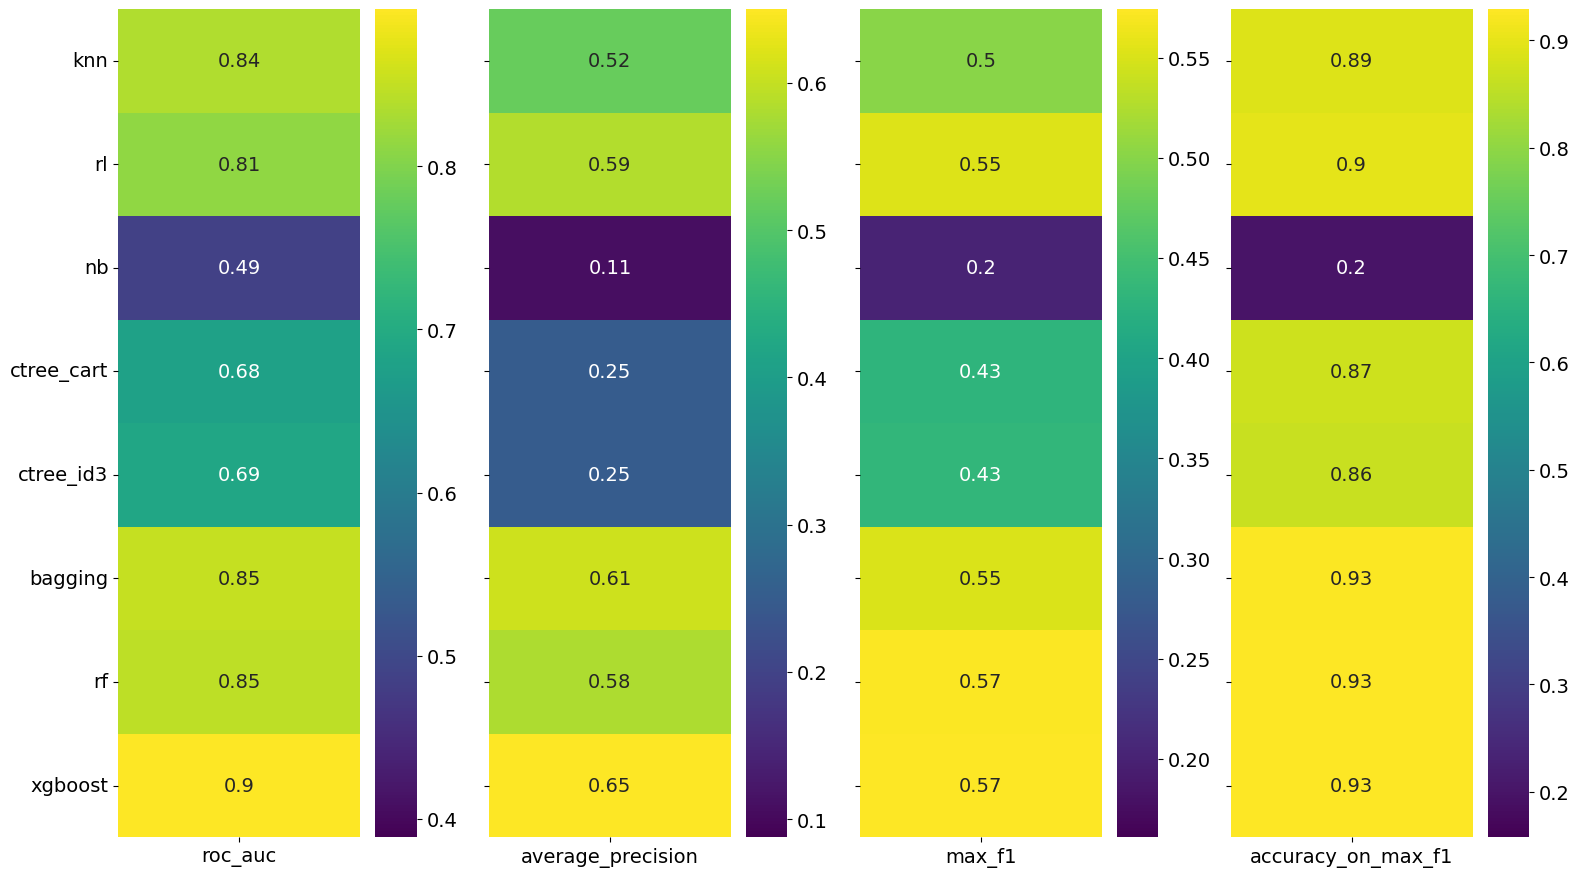

In [42]:
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14)

fig, axs = plt.subplots(1, 4 , figsize=(16, 9), sharey=True)

for i, ax in enumerate(axs):
    sns.heatmap(
        df_metrics.iloc[:, [i]],
        ax=ax,
        vmin=df_metrics.iloc[:, [i]].min()*0.8,
        vmax=df_metrics.iloc[:, [i]].max(),
        annot=True,
        cmap='viridis'
    )

fig.tight_layout()

Definamos el umbral de decisión.

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

In [43]:
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([skm.f1_score(y_test, xgb_val_preds>th) for th in ths])]
best_th

np.float64(0.5045045045045045)

## GridSearchCV

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
param_grid = {
    'classificador__n_estimators': [100, 200,300],
    'classificador__max_depth': [3, 5],
    'classificador__learning_rate': [0.01, 0.1],
    'classificador__subsample': [0.7, 0.9],
    'classificador__colsample_bytree': [0.7, 0.9],
    'classificador__gamma': [0.1, 0.2],
    'classificador__reg_alpha': [0, 0.1],
    'classificador__reg_lambda': [1, 1.5]
}

In [46]:
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='f1',   #
    cv=3,                 # k-fold cross-validation
    verbose=2,            # para que veas el progreso
    n_jobs=-1             # usa todos los núcleos disponibles
)

In [47]:
# Entrenamiento con cronómetro
start = time()
grid_search.fit(X_train, y_train)
end = time()

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


KeyboardInterrupt: 

In [ ]:
print('Mejores hiperparámetros encontrados:', grid_search.best_params_)
print('Mejor score (f1):', grid_search.best_score_)

In [ ]:
# Tomar el mejor modelo
best_model = grid_search.best_estimator_


Espera!! Deberiamos reentrenar con todos los datos?

In [ ]:
start = time()
best_model.fit(X, y)
end = time()

print(
    'Tiempo Entrenamiento Regresión Logistica con todos los datos:',
    str(timedelta(seconds=end-start))
)

Ahora si, guardemos el mejor modelo hasta ahora

In [ ]:
with open("xgb_pipeline.pkl", "wb") as f:
    pickle.dump(best_model, f)

## Generar Submission

Realicemos predicciones sobre el test set de la competencia

In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
test_df = pd.read_parquet("df_test.parquet")


In [ ]:
test_df = pd.read_parquet("df_test.parquet")
test_df['EDAD_COMPLICACION'] = (test_df['Fecha_cero'] - test_df['FECHA_NACIMIENTO']).dt.days // 365

test_df[columnas_numerico] = X[columnas_numerico].astype(float)
test_df[columnas_categ] = X[columnas_categ].astype(str)

submission_pred = best_model.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_xgb.csv", index=False)
from google.colab import files
files.download("submission_xgb.csv")